# Анализ результатов А/B теста для мобильного приложения.


## Описание проекта

У пользователей есть возможность покупать продукты питания через мобильное приложения.
* Необходимо изучить воронку продаж, узнать, как пользователи доходят до покупки, сколько пользователей доходит до покупки, а сколько — «застревает» на определенных этапах.
* Даны результаты A/A/B-теста, где пользователи разбыты на 3 группы: 2 контрольные со старыми шрифтами и одну экспериментальную — с новыми. Необходимо выяснить, какой шрифт лучше. 

## Оглавление

* <b><a href="#data_discribe">1. Описание данных</a></b>
    * <a href="#resume1">1.1 Вывод</a>
* <b><a href="#data_preprocessing">2. Предобработка данных</a></b>
    * <a href='#result2'>2.4 Вывод</a>
* <b><a href="#data_analiz">3. Анализ данных</a></b>
    * <a href="#data_analiz1">3.1 События в логе </a>
    * <a href="#data_analiz2">3.2 Пользователи в логе</a>
    * <a href='#data_analiz3'>3.3 Среднее количество событий на одного пользователя</a>
    * <a href="#data_analize4">3.4 Актуальный период данных</a>
    * <a href="#data_analiz5">3.5 Вывод</a>
* <b><a href="#data_view">4. Воронка событий </a></b>
    * <a href='#data_view1'>4.1 Воронка с учётом последовательности событий</a>
    * <a href='#data_view2'>4.2 Вывод</a>
* <b><a href="#stat">5. Анализ результатов эксперимента </a></b>
    * <a href='#stat1'>5.1 Вывод</a>
* <b><a href="#result">6. Общий вывод </a></b>

## Описание данных <a id="data_discribe"></a>

In [31]:
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
from plotly import graph_objects as go
from scipy import stats as st
import math as mth
import numpy as np

In [32]:
try:
    log = pd.read_csv('https://code.s3.yandex.net/datasets/logs_exp.csv', sep='\t') 
except:
    log = pd.read_csv('logs_exp.csv', sep='\t')
    
def display_data(data,rows_num,description):
    if description:
        print(description)
    rows_num = rows_num or 5
    display(data.head(rows_num))
    print('')
    print('Общая информация')
    data.info()
    print('')
    null_values = data.isnull().sum()
    null_len =  len(null_values[null_values > 0])
    if null_len == 0:
        print('Сумма пропущенных значений: 0')
    else:
        print('Сумма пропущенных значений:')
        display(null_values[null_values > 0])
    print('Дубликатов строк: {:.0f}'.format(data.duplicated().sum()))
    print(' ')

display_data(log,5,'Таблица log с данными о действиях пользователя, или событиях')

Таблица log с данными о действиях пользователя, или событиях


,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248



Общая информация
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB

Сумма пропущенных значений: 0
Дубликатов строк: 413
 


Столбцы таблицы
* EventName — название события;
* DeviceIDHash — уникальный идентификатор пользователя;
* EventTimestamp — время события;
* ExpId — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.

### Вывод <a id="resume1"></a>

* В данных нет пропущенных значений, но присутствуют дубликаты строк. Удалим эти строки.
* Переведем время события из timestamp в локальное время

## Предобработка данных <a id="data_preprocessing"></a>

Удалим дубликаты

In [33]:
log = log.drop_duplicates()
log.duplicated().sum()

0

Переименуем столбцы

In [34]:
log.set_axis(['event_name','device_id_hash','event_datetime','exp_id'],axis='columns',inplace=True)
display(log.columns)

Index(['event_name', 'device_id_hash', 'event_datetime', 'exp_id'], dtype='object')

Переведем время события из timestamp в локальное время

In [35]:
log['event_datetime'] = pd.to_datetime(log['event_datetime'], unit='s')
log.head(5)
log.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 243713 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   event_name      243713 non-null  object        
 1   device_id_hash  243713 non-null  int64         
 2   event_datetime  243713 non-null  datetime64[ns]
 3   exp_id          243713 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 9.3+ MB


Добавим столбец с датой события отдельно

In [36]:
log['event_date'] = log['event_datetime'].dt.date
log.head(5)

,event_name,device_id_hash,event_datetime,exp_id,event_date
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25


### Вывод <a id='result2'></a>

Дубликаты удалены, выделен столбец с датой события

## Анализ данных <a id="data_analiz"></a>

### События в логе <a id="data_analiz1"></a>

In [37]:
count_events = log.groupby('event_name', as_index=False).count()
display(count_events)
print('Всего событий:', count_events['device_id_hash'].sum())

,event_name,device_id_hash,event_datetime,exp_id,event_date
0,CartScreenAppear,42668,42668,42668,42668
1,MainScreenAppear,119101,119101,119101,119101
2,OffersScreenAppear,46808,46808,46808,46808
3,PaymentScreenSuccessful,34118,34118,34118,34118
4,Tutorial,1018,1018,1018,1018


Всего событий: 243713


### Пользователи в логе <a id="data_analiz2"></a>

In [38]:
print('Всего уникальных пользователей: ', len(log['device_id_hash'].unique()))

Всего уникальных пользователей:  7551


### Среднее количество событий на одного пользователя <a id="data_analiz3"></a>

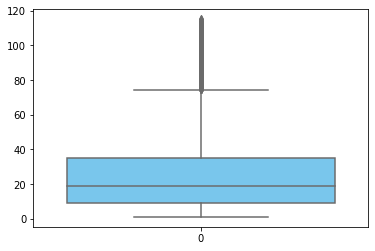

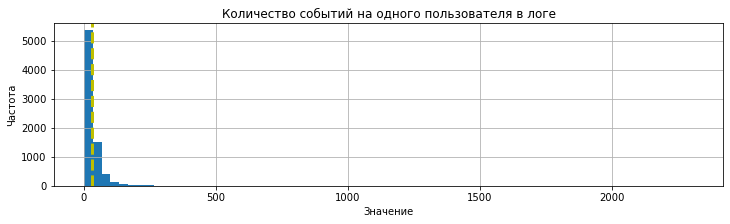

,device_id_hash,count_events
count,7.551000e+03,7551.000000
mean,4.677319e+18,32.275593
std,2.655343e+18,65.154219
min,6.888747e+15,1.000000
25%,2.397700e+18,9.000000
50%,4.688022e+18,20.000000
75%,7.007353e+18,37.000000
max,9.222603e+18,2307.000000


Среднее количество событий на одного пользователя: 32


In [39]:
n_events_mean = log.pivot_table(index='device_id_hash', values='event_name', aggfunc=['count'])
n_events_mean_records = pd.DataFrame(n_events_mean.to_records())
n_events_mean_records.set_axis(['device_id_hash','count_events'],axis='columns',inplace=True)
events_per_user_mean = round(n_events_mean_records['count_events'].mean())


#boxplot
sns.boxplot(data=n_events_mean_records.loc[ n_events_mean_records['count_events'] < \
                n_events_mean_records['count_events'].quantile(0.97)]['count_events'],color="#66CCFF")
plt.show()

#histogram
n_events_mean.plot(title='Количество событий на одного пользователя в логе',\
             figsize=(12,3), kind='hist', grid='True', legend=None, bins=70)

plt.axvline(x=events_per_user_mean, linewidth=3,color='y',linestyle='--')
plt.xlabel('Значение')
plt.ylabel('Частота')
plt.show()

display(n_events_mean_records.describe())
print('Среднее количество событий на одного пользователя:', events_per_user_mean)

<AxesSubplot:title={'center':'Количество событий на одного пользователя в логе'}, ylabel='Frequency'>

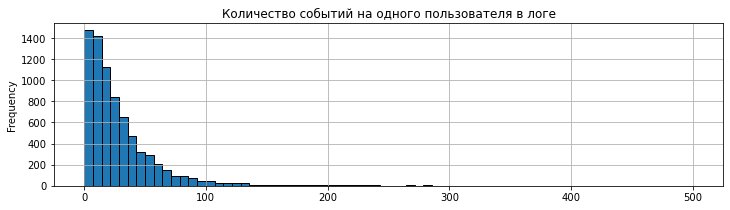

In [40]:
n_events_mean.plot(title='Количество событий на одного пользователя в логе',\
                   figsize=(12,3), kind='hist', grid='True', legend=None, bins=70, range=(0,500), 
                   ec='black')

### Актуальный период данных <a id="data_analiz4"></a>

In [41]:
date_min = log['event_date'].min()
date_max = log['event_date'].max()
print('Период событий в логе: с',date_min.strftime('%d-%m-%Y'),'по',date_max.strftime('%d-%m-%Y'))

Период событий в логе: с 25-07-2019 по 07-08-2019


In [42]:
display(log.pivot_table(index='event_date', columns='event_name', values='event_datetime', \
                        aggfunc=['count']))

count                                      \
event_name CartScreenAppear MainScreenAppear OffersScreenAppear   
event_date                                                        
2019-07-25              2.0              4.0                1.0   
2019-07-26              6.0             16.0                4.0   
2019-07-27              4.0             39.0                9.0   
2019-07-28             24.0             53.0               16.0   
2019-07-29             23.0            132.0               20.0   
2019-07-30             49.0            279.0               51.0   
2019-07-31            257.0           1250.0              374.0   
2019-08-01           6217.0          17945.0             6988.0   
2019-08-02           6522.0          16792.0             6924.0   
2019-08-03           6374.0          14832.0             6795.0   
2019-08-04           6155.0          15203.0             6487.0   
2019-08-05           6248.0          18005.0             6666.0   
2019-08-06           5733.0          18761.0             6533.0   
2019-08-07           5054.0          15790.0             5940.0   

                                             
event_name PaymentScreenSuccessful Tutorial  
event_date                                   
2019-07-25                     2.0      NaN  
2019-07-26                     3.0      2.0  
2019-07-27                     1.0      2.0  
2019-07-28                    12.0      NaN  
2019-07-29                     9.0      NaN  
2019-07-30                    33.0      NaN  
2019-07-31                   140.0      9.0  
2019-08-01                  4771.0    220.0  
2019-08-02                  5148.0    168.0  
2019-08-03                  5119.0    162.0  
2019-08-04                  4983.0    140.0  
2019-08-05                  5024.0    115.0  
2019-08-06                  4631.0    130.0  
2019-08-07                  4242.0     70.0

Для дальнейшего анализа рассмотрим данные только за август, так как, судя по графику и таблице, данные в логе за последние дни июля не полные 

In [43]:
data_old = log.loc[log['event_date'] < pd.to_datetime('2019-08-01')]
data = log.loc[log['event_date'] >= pd.to_datetime('2019-08-01')]

print('Всего потеряем пользователей: ', \
   len(data_old['device_id_hash'].unique()) - \
      len(data_old.merge(data, on='device_id_hash', how='inner')['device_id_hash'].unique()))

Всего потеряем пользователей:  17


In [44]:
print('Всего потеряем событий: ', data_old['event_name'].count(), \
      '- {:.2%} от данных'.format(data_old['event_name'].count()/log['event_name'].count()))

Всего потеряем событий:  2826 - 1.16% от данных


In [45]:
display(data.groupby('exp_id', as_index=False).count())

,exp_id,event_name,device_id_hash,event_datetime,event_date
0,246,79302,79302,79302,79302
1,247,77022,77022,77022,77022
2,248,84563,84563,84563,84563


В данных остались пользователи из всех трёх экспериментальных групп

### Вывод <a id="data_analiz5"></a>

В логе информация о 7551 пользователеб на каждого из них приходится в среднем по 32 записи о событиях. Актуальные данные в логе за август 

## Воронка событий  <a id="data_view"></a>

In [46]:
data.groupby('event_name', as_index=False).agg({'event_datetime': 'count'}).\
    sort_values(by='event_datetime', ascending=False)

,event_name,event_datetime
1,MainScreenAppear,117328
2,OffersScreenAppear,46333
0,CartScreenAppear,42303
3,PaymentScreenSuccessful,33918
4,Tutorial,1005


События в логе: "Открытие главного экрана", "Католог", "Корзина", "Страница успешной оплаты", "Руководство пользователя". Самое "популярное" событие - открытие главного экрана (117328 записей).

In [47]:
users_count = data.groupby('event_name', as_index=False).agg({'device_id_hash': 'nunique'}).\
        sort_values(by='device_id_hash', ascending=False)

print('Всего уникальных пользователей: ', len(data['device_id_hash'].unique()))

users_count['share'] = round(users_count['device_id_hash']/len(data['device_id_hash'].unique()),2)                                               
print('Количество пользователей совершивших каждое событие и доля пользователей,\
 совершивших событие хотя бы раз')
display(users_count)

Всего уникальных пользователей:  7534
Количество пользователей совершивших каждое событие и доля пользователей, совершивших событие хотя бы раз


,event_name,device_id_hash,share
1,MainScreenAppear,7419,0.98
2,OffersScreenAppear,4593,0.61
0,CartScreenAppear,3734,0.50
3,PaymentScreenSuccessful,3539,0.47
4,Tutorial,840,0.11


Цепочка событий воронки: 
* "Главный экран" 
* "Страница товара" 
* "Корзина" 
* "Успешная оплата"

Выведем воронку, которая нам показывает, сколько у нас юзеров на каком из этапов. Конечно, это "воронка" с натяжкой, потому что это не те пользователи, которые прошли весь путь от и до.<br/>
Будет возможность сравнить 2 воронки.

In [48]:
fig_1 = go.Figure(
    go.Funnel(
        y=[
            'Открыли главную страницу',
            'Открыли каталог',
            'Положили товары в корзину',
            'Оплатили',
        ],
        x=users_count['device_id_hash'],
        textinfo = "value+percent initial",
        marker = {"color": "#66CCFF"}
    )
)

fig_1.update_layout(margin=dict(l=0, r=0, t=30, b=0),
                  height=300,
                  width=800,
                  title_text='Воронка событий по уникальным пользователям на каждом этапе', title_x=0.6
                 )

fig_1.show()

In [49]:
users_tutorial = data.pivot_table(
        index='device_id_hash', columns='event_name', values='event_datetime', aggfunc='min'
    ) 
display(pd.DataFrame(users_tutorial.to_records()).sort_values(by='Tutorial').head(5))

,device_id_hash,CartScreenAppear,MainScreenAppear,OffersScreenAppear,PaymentScreenSuccessful,Tutorial
2973,3737462046622621720,2019-08-01 13:30:20,2019-08-01 00:08:00,2019-08-01 00:08:58,2019-08-01 13:30:37,2019-08-01 00:07:28
4487,5587388800188073787,2019-08-01 02:21:27,2019-08-01 02:19:50,2019-08-01 02:19:52,2019-08-01 02:21:27,2019-08-01 02:19:41
2371,2988069914968447512,NaT,2019-08-01 02:35:19,NaT,NaT,2019-08-01 02:35:04
1495,1884616937397676465,2019-08-01 03:04:05,2019-08-01 03:01:50,2019-08-01 03:04:15,2019-08-01 03:04:05,2019-08-01 03:01:11
4359,5422877498318042547,2019-08-01 03:40:05,2019-08-01 03:05:20,2019-08-01 03:05:35,2019-08-02 05:45:55,2019-08-01 03:04:35


In [50]:
def funnel_by_data(data):
    users = data.pivot_table(
        index='device_id_hash', columns='event_name', values='event_datetime', aggfunc='min'
    ) 
    display(users.head(5))
    step_1 = ~users['MainScreenAppear'].isna()
    step_2 = step_1 & (users['OffersScreenAppear'] > users['MainScreenAppear'])
    step_3 = step_2 & (users['CartScreenAppear'] > users['OffersScreenAppear'])
    step_4 = step_3 & (users['PaymentScreenSuccessful'] > users['CartScreenAppear'])

    n_main_screen = users[step_1].shape[0]
    n_offers_screen = users[step_2].shape[0]
    n_cart_screen = users[step_3].shape[0]
    n_payment_screen = users[step_4].shape[0]

    print("Главный экран", n_main_screen)
    print('Каталог', n_offers_screen)
    print('Корзина', n_cart_screen)
    print('Оплата', n_payment_screen)

    res = pd.DataFrame(["Главный экран",'Каталог','Корзина','Оплата'], columns = {'events'})

    res['n_users'] = [n_main_screen,n_offers_screen,n_cart_screen,n_payment_screen]
    res['res']      = round(res['n_users']/res['n_users'][0],2)
    res['step_res'] = [1, res['n_users'][1]/res['n_users'][0], \
                        res['n_users'][2]/res['n_users'][1],res['n_users'][3]/res['n_users'][2]]
    res['step_res'] = round(res['step_res'],2)
    display(res)


    fig = go.Figure(
        go.Funnel(
            y=[
                'Открыли главную страницу',
                'Открыли каталог',
                'Положили товары в корзину',
                'Оплатили',
            ],
            x=res['n_users'],
            textinfo = "value+percent initial",
            marker = {"color": "#66CCFF"}
        )
    )

    fig.update_layout(margin=dict(l=0, r=0, t=10, b=0),
                      height=300,
                      width=800)

    fig.show()
    
    return res

In [51]:
df_for_2nd_funnel = funnel_by_data(data)

event_name,CartScreenAppear,MainScreenAppear,OffersScreenAppear,PaymentScreenSuccessful,Tutorial
device_id_hash,,,,,
6888746892508752,NaT,2019-08-06 14:06:34,NaT,NaT,NaT
6909561520679493,2019-08-06 18:52:58,2019-08-06 18:52:54,2019-08-06 18:53:04,2019-08-06 18:52:58,NaT
6922444491712477,2019-08-04 14:19:40,2019-08-04 14:19:33,2019-08-04 14:19:46,2019-08-04 14:19:40,NaT
7435777799948366,NaT,2019-08-05 08:06:34,NaT,NaT,NaT
7702139951469979,2019-08-02 14:28:45,2019-08-01 04:29:54,2019-08-01 04:29:56,2019-08-02 14:28:45,NaT


Главный экран 7419
Каталог 4201
Корзина 1767
Оплата 454


,events,n_users,res,step_res
0,Главный экран,7419,1.00,1.00
1,Каталог,4201,0.57,0.57
2,Корзина,1767,0.24,0.42
3,Оплата,454,0.06,0.26


In [52]:

fig = go.Figure()

fig.add_trace(go.Funnel(
    name = 'Воронка без учета<br> последовательности',
    y=[
            'Открыли главную страницу',
            'Открыли каталог',
            'Положили товары в корзину',
            'Оплатили',
        ],
    x=users_count['device_id_hash'],
    textinfo = "value+percent initial"))

fig.add_trace(go.Funnel(
    name = 'Воронка с учетом<br> последовательности',
    orientation = "h",
    y=[
            'Открыли главную страницу',
            'Открыли каталог',
            'Положили товары в корзину',
            'Оплатили',
        ],
    x=df_for_2nd_funnel['n_users'],
    textposition = "auto",
    textinfo = "value+percent initial"))


fig.show()

Начинается всё с одинакового количества пользователей, что ожидаемо. На следующем этапе 5% (392) пользователей - это те, кто пришёл сразу же к каталогу, то есть они не были на главном экране. На этапе корзины - таких уже 2000 пользователей (кто-то из них не был на главном экране, кто-то - на экране каталога). Видим, какая часть пользователей от общего числа попала на каждый конкретный этап с учетом последовательности выполняемых событий, а какая - нет.

### Воронка с учётом последовательности событий <a id="data_view1"></a>

In [53]:
data = data[data['event_name'] != 'Tutorial']
funnel_by_data( data )

event_name,CartScreenAppear,MainScreenAppear,OffersScreenAppear,PaymentScreenSuccessful
device_id_hash,,,,
6888746892508752,NaT,2019-08-06 14:06:34,NaT,NaT
6909561520679493,2019-08-06 18:52:58,2019-08-06 18:52:54,2019-08-06 18:53:04,2019-08-06 18:52:58
6922444491712477,2019-08-04 14:19:40,2019-08-04 14:19:33,2019-08-04 14:19:46,2019-08-04 14:19:40
7435777799948366,NaT,2019-08-05 08:06:34,NaT,NaT
7702139951469979,2019-08-02 14:28:45,2019-08-01 04:29:54,2019-08-01 04:29:56,2019-08-02 14:28:45


Главный экран 7419
Каталог 4201
Корзина 1767
Оплата 454


,events,n_users,res,step_res
0,Главный экран,7419,1.00,1.00
1,Каталог,4201,0.57,0.57
2,Корзина,1767,0.24,0.42
3,Оплата,454,0.06,0.26


,events,n_users,res,step_res
0,Главный экран,7419,1.00,1.00
1,Каталог,4201,0.57,0.57
2,Корзина,1767,0.24,0.42
3,Оплата,454,0.06,0.26


Из столбца итоговой конверсии (res) видно, что из 100 пользователей  с главной страницы дошли до оплаты и оплатили заказ всего 6 человек. Наибольшие "потери" при оплате заказа, только 26%  пользователей оплатили заказ уже добавленный в корзину

### Вывод <a id="data_view2"></a>

* Пользователи добавляют продукты в корзину, но только 26% из них оплачивает заказ. 11% пользователей открывали Tutorial. Возможно, на этапе оплаты заказа возникают определенные трудности и стоит внести изменения на страницу оплаты.
* 2% пользователей не открывали главный экран, те подходили альтернативным путём.

## Анализ результатов эксперимента <a id="stat"></a>

In [54]:
count_users_by_groups = data.groupby('exp_id', as_index=False).agg({'device_id_hash': 'nunique'})
display(count_users_by_groups)

,exp_id,device_id_hash
0,246,2483
1,247,2512
2,248,2535


В экспериментальных группах 246-2483, 247-2512, 248-2535 пользователей. 

In [55]:
test_data = pd.DataFrame(data.\
                pivot_table(index='event_name', columns='exp_id', values='device_id_hash', aggfunc='nunique').\
                         to_records()).sort_values(by='246', ascending = False)

test_data['246_conv'] = round(test_data['246']/test_data['246'][1],2)
test_data['247_conv'] = round(test_data['247']/test_data['247'][1],2)
test_data['248_conv'] = round(test_data['248']/test_data['248'][1],2)
display(test_data)

,event_name,246,247,248,246_conv,247_conv,248_conv
1,MainScreenAppear,2450,2476,2493,1.00,1.00,1.00
2,OffersScreenAppear,1542,1520,1531,0.63,0.61,0.61
0,CartScreenAppear,1266,1238,1230,0.52,0.50,0.49
3,PaymentScreenSuccessful,1200,1158,1181,0.49,0.47,0.47


In [56]:
events = {'MainScreenAppear':'Открыли главную страницу',
          'OffersScreenAppear':'Открыли каталог',
          'CartScreenAppear':'Положили товары в корзину',
          'PaymentScreenSuccessful':'Оплатили'
         }

* Н0 - Между конверсиями нет существенной разницы
* H1 - Между долями есть существенная разница

In [57]:
def test(success1, success2, trial1, trial2, alpha, n_exp):
    successes = np.array([success1, success2])
    trials = np.array([trial1, trial2])

    # пропорция успехов в первой группе:
    p1 = successes[0]/trials[0]

    # пропорция успехов во второй группе:
    p2 = successes[1]/trials[1]

    # пропорция успехов в комбинированном датасете:
    p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])

    # разница пропорций в датасетах
    difference = p1 - p2 

    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))

    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1)
    
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    print('p-значение: ', p_value)
    
    bonferroni_alpha = alpha / n_exp

    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
        print(
            'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'
        ) 
    print('')

n_exp  = 16 #4 события в воронке и 4 группы 246, 247, 248 и 246+247
alpha1 = .05 # критический уровень статистической значимости
users_by_group_dict = count_users_by_groups.set_index('exp_id')['device_id_hash'].to_dict()
print(str.upper('Различие между контрольными группами'))
for i in range(0,4):
    print(events[test_data['event_name'][i]])
    test(test_data['246'][i], test_data['247'][i], users_by_group_dict[246],\
         users_by_group_dict[247], alpha1, n_exp)  

РАЗЛИЧИЕ МЕЖДУ КОНТРОЛЬНЫМИ ГРУППАМИ
Положили товары в корзину
p-значение:  0.22867643757335676
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Открыли главную страницу
p-значение:  0.7526703436483038
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Открыли каталог
p-значение:  0.24786096925282264
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Оплатили
p-значение:  0.11446627829276612
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



In [58]:
print(str.upper('Различие между первой контрольной группой и группой с измененным шрифтом для списка событий'))
for i in range(0,4):
    print(events[test_data['event_name'][i]])
    test(test_data['246'][i], test_data['248'][i], users_by_group_dict[246],\
         users_by_group_dict[248], alpha1, n_exp)
    
print(str.upper('Различие между второй контрольной группой и группой с измененным шрифтом для списка событий'))        
for i in range(0,4):
    print(events[test_data['event_name'][i]])
    test(test_data['248'][i], test_data['247'][i], users_by_group_dict[248],\
         users_by_group_dict[247], alpha1, n_exp)

РАЗЛИЧИЕ МЕЖДУ ПЕРВОЙ КОНТРОЛЬНОЙ ГРУППОЙ И ГРУППОЙ С ИЗМЕНЕННЫМ ШРИФТОМ ДЛЯ СПИСКА СОБЫТИЙ
Положили товары в корзину
p-значение:  0.08067367598823139
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Открыли главную страницу
p-значение:  0.3387114076159288
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Открыли каталог
p-значение:  0.21442476639710506
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Оплатили
p-значение:  0.21693033984516674
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

РАЗЛИЧИЕ МЕЖДУ ВТОРОЙ КОНТРОЛЬНОЙ ГРУППОЙ И ГРУППОЙ С ИЗМЕНЕННЫМ ШРИФТОМ ДЛЯ СПИСКА СОБЫТИЙ
Положили товары в корзину
p-значение:  0.5878284605111943
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Открыли главную страницу
p-значение:  0.5194964354051703
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Открыли каталог
p-зн

Так как каждый пользователь входит только в одну контрольную группу, то можем сложить значения для объединенной группы, чтобы сравнивать ее с измененной группой

In [59]:
print(str.upper('Различие между объединенной контрольной группой и группой с измененным шрифтом для списка событий'))
for i in range(0,4):
    print(events[test_data['event_name'][i]])
    test(test_data['248'][i], test_data['246'][i] + test_data['247'][i], 
         users_by_group_dict[248], users_by_group_dict[246] + users_by_group_dict[247], alpha1, n_exp)

РАЗЛИЧИЕ МЕЖДУ ОБЪЕДИНЕННОЙ КОНТРОЛЬНОЙ ГРУППОЙ И ГРУППОЙ С ИЗМЕНЕННЫМ ШРИФТОМ ДЛЯ СПИСКА СОБЫТИЙ
Положили товары в корзину
p-значение:  0.18683558686831558
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Открыли главную страницу
p-значение:  0.3486684291093256
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Открыли каталог
p-значение:  0.44582745409482394
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Оплатили
p-значение:  0.6107918742187335
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



заменим уровень статистической значимости на 0.1

In [60]:
alpha_new =  0.1
print(str.upper('Различие между контрольными группами'))
for i in range(0,4):
    print(events[test_data['event_name'][i]])
    test(test_data['246'][i], test_data['248'][i], users_by_group_dict[246], \
         users_by_group_dict[248], alpha_new, n_exp)
    
print(str.upper('Различие между первой контрольной группой и группой с измененным шрифтом для списка событий'))
for i in range(0,4):
    print(events[test_data['event_name'][i]])
    test(test_data['246'][i], test_data['248'][i], users_by_group_dict[246], \
         users_by_group_dict[248], alpha_new, n_exp)
    
print(str.upper('Различие между второй контрольной группой и группой с измененным шрифтом для списка событий'))    
for i in range(0,4):
    print(events[test_data['event_name'][i]])
    test(test_data['248'][i], test_data['247'][i], users_by_group_dict[248],\
         users_by_group_dict[247], alpha_new, n_exp)
    
print(str.upper('Различие между объединенной контрольной группой и группой с измененным шрифтом для списка событий'))
for i in range(0,4):
    print(events[test_data['event_name'][i]])
    test(test_data['248'][i], test_data['246'][i] + test_data['247'][i], 
         users_by_group_dict[248], users_by_group_dict[246] + users_by_group_dict[247],\
         alpha_new,n_exp)

РАЗЛИЧИЕ МЕЖДУ КОНТРОЛЬНЫМИ ГРУППАМИ
Положили товары в корзину
p-значение:  0.08067367598823139
Отвергаем нулевую гипотезу: между долями есть значимая разница

Открыли главную страницу
p-значение:  0.3387114076159288
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Открыли каталог
p-значение:  0.21442476639710506
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Оплатили
p-значение:  0.21693033984516674
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

РАЗЛИЧИЕ МЕЖДУ ПЕРВОЙ КОНТРОЛЬНОЙ ГРУППОЙ И ГРУППОЙ С ИЗМЕНЕННЫМ ШРИФТОМ ДЛЯ СПИСКА СОБЫТИЙ
Положили товары в корзину
p-значение:  0.08067367598823139
Отвергаем нулевую гипотезу: между долями есть значимая разница

Открыли главную страницу
p-значение:  0.3387114076159288
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Открыли каталог
p-значение:  0.21442476639710506
Не получилось отвергнуть нулевую гипотезу, нет основани

### Вывод <a id="stat1"></a>

Разница в 2-3% между конверсиями оказалась статистически не значимой для критического уровня статистической значимости 0.05. 
Однако, для события "Положили товары в корзину" при alpha = 0,1 с р-значением 8% есть различия. Тогда получаем, что опасения менеджеров были не напрасны, и шрифт менять не стоит

Увеличивая уровень значимости, мы увеличиваем шансы отвергнуть нулевую гипотезу, а с другой стороны мы также увеличиваем и вероятность ошибки первого рода. Поскольку наша выборка не такая уж маленькая, пользователей в каждой группе больше 1000, то корректно взять alpha = 0.05 или меньше

## Общий вывод <a id="result"></a>

* В логе информация о 7551 пользователе, на каждого из них приходится в среднем по 32 записи о событиях. Актуальные данные в логе с 01.08.2019 по 07.08.2019
* Конверсия из пользователей, которые открыли главный экран в покупателей оплативших заказ всего 6%. Только 26% из тех, кто положил продукты в корзину, оплачивает заказ. Необходимо пересмотреть экран оплаты товаров. Возможно, пользователь испытывает трудности при вводе или выборе данных карты
* Шрифт в приложении менять не стоит, так как нет статистической значимости для разницы конверсий контрольной группы и группы, которой показывали измененный шрифт.